In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.metrics import classification_report, accuracy_score

pd.set_option('display.float_format', lambda x: '%.0f' % x)

# Configuração para os gráficos
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (15, 8)

In [2]:
df_transacoes = pd.read_excel('dados/transações-desafio.xlsx')
df_mercado = pd.read_excel('dados/mercado-desafio.xlsx')

print("--- Informações sobre Transações ---")
df_transacoes.info()
print("\n--- Primeiras 5 Transações ---")
print(df_transacoes.head())

print("\n\n--- Informações sobre Mercado ---")
df_mercado.info()
print("\n--- Primeiros 5 Preços de Mercado ---")
print(df_mercado.head())

--- Informações sobre Transações ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9513 entries, 0 to 9512
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          9513 non-null   datetime64[ns]
 1   Time          9513 non-null   object        
 2   Company       9513 non-null   object        
 3   Seller ID     9513 non-null   int64         
 4   Buyer ID      9513 non-null   int64         
 5   Price         9513 non-null   float64       
 6   Amount        9512 non-null   float64       
 7   Product       9513 non-null   object        
 8   origin_city   9511 non-null   object        
 9   origin_state  9513 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 743.3+ KB

--- Primeiras 5 Transações ---
        Date      Time  Company  Seller ID   Buyer ID  Price  Amount Product  \
0 2024-11-04  14:21:17  Polaris  100000060  200000027    124 

In [3]:
# Converter colunas de data
# 1. Converter a coluna 'Date' em ambos os dataframes
df_transacoes['Date'] = pd.to_datetime(df_transacoes['Date'])
df_mercado['Date'] = pd.to_datetime(df_mercado['Date'])

# 2. Renomear a coluna de preço no df_mercado ANTES de unir.
# Isso evita a criação confusa de 'Price_x' e 'Price_y'.
# 'Price' em df_transacoes é o preço real da transação.
# 'Price' em df_mercado é o preço geral do mercado naquele dia.
df_mercado.rename(columns={'Price': 'Market_Price'}, inplace=True)

# 3. Fazer a junção ('merge') usando as chaves corretas: 'Date' e 'Product'
df_completo = pd.merge(df_transacoes, df_mercado, on=['Date', 'Product'], how='left')

# 4. Imprimir para verificar o resultado
print("--- DataFrame Completo ---")
print(df_completo.head())

# Verificar as novas colunas. Agora você terá 'Price' e 'Market_Price'
print("\nNovas colunas:", df_completo.columns)

--- DataFrame Completo ---
        Date      Time Company_x  Seller ID   Buyer ID  Price  Amount Product  \
0 2024-11-04  14:21:17   Polaris  100000060  200000027    124    2291    Soja   
1 2024-11-04  14:21:17   Polaris  100000060  200000027    124    2291    Soja   
2 2024-11-04  14:21:17   Polaris  100000060  200000027    124    2291    Soja   
3 2024-11-04  14:21:17   Polaris  100000060  200000027    124    2291    Soja   
4 2024-11-04  14:21:17   Polaris  100000060  200000027    124    2291    Soja   

   origin_city origin_state Company_y   Origin_city Origin_state  \
0  Porto Velho           RO   Polaris     Abadiânia           GO   
1  Porto Velho           RO   Polaris     Abadiânia           GO   
2  Porto Velho           RO   Polaris  Abelardo Luz           SC   
3  Porto Velho           RO   Polaris      Alegrete           RS   
4  Porto Velho           RO   Polaris      Alexânia           GO   

  Destination_city Destination_state  Market_Price  CBOT  
0       Cristalina

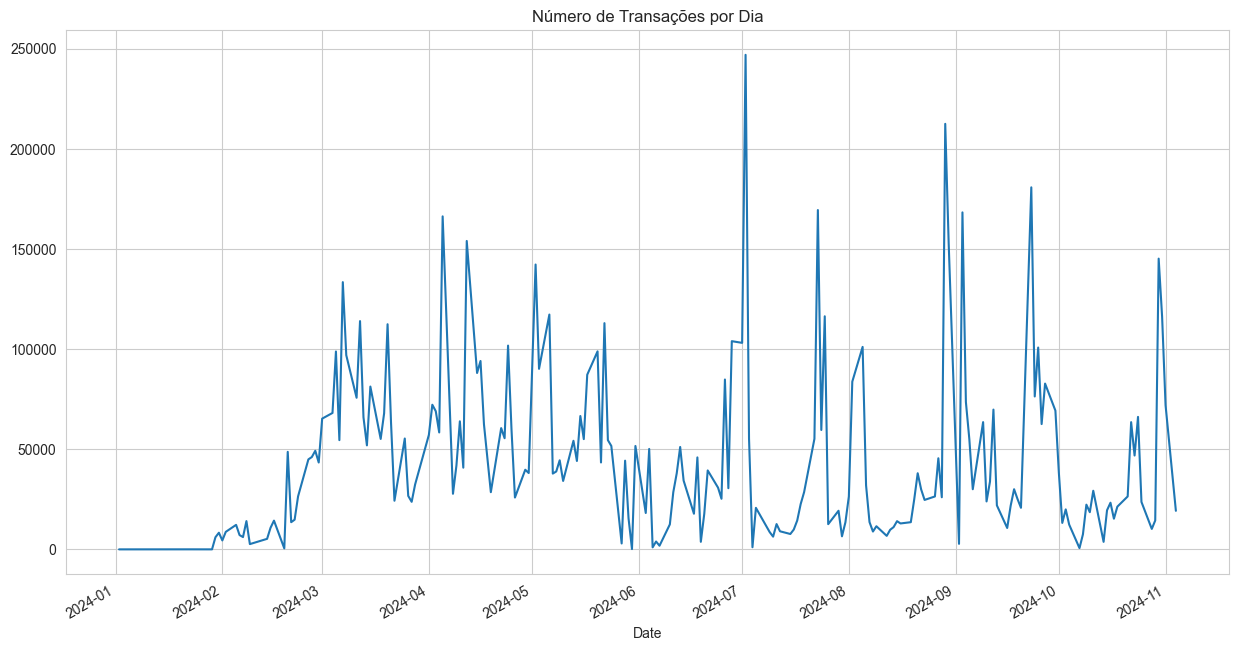

In [4]:
transacoes_por_dia = df_completo.groupby('Date').size()
transacoes_por_dia.plot(title='Número de Transações por Dia')
plt.show()

In [5]:
print("Iniciando Engenharia de Features (Numéricas + Dólar)...")

# --- A: FEATURES NUMÉRICAS (Recência e Frequência) ---
df_completo = df_completo.sort_values(by='Date')
todos_vendedores = df_completo['Seller ID'].unique()
todas_datas = pd.date_range(start=df_completo['Date'].min(), end=df_completo['Date'].max(), freq='D')
df_base = pd.DataFrame([(v, d) for v in todos_vendedores for d in todas_datas], columns=['Seller ID', 'Date'])
transacoes_diarias = df_completo.groupby(['Date', 'Seller ID']).size().reset_index(name='transacoes_dia')
df_features = pd.merge(df_base, transacoes_diarias, on=['Date', 'Seller ID'], how='left').fillna(0)
df_features = df_features.sort_values(by=['Seller ID', 'Date'])
df_features['freq_7d'] = df_features.groupby('Seller ID')['transacoes_dia'].transform(lambda x: x.rolling(window=7, min_periods=1).sum())
df_features['freq_30d'] = df_features.groupby('Seller ID')['transacoes_dia'].transform(lambda x: x.rolling(window=30, min_periods=1).sum())
df_features['freq_90d'] = df_features.groupby('Seller ID')['transacoes_dia'].transform(lambda x: x.rolling(window=90, min_periods=1).sum())
df_features['ultima_transacao'] = df_features.apply(lambda row: row['Date'] if row['transacoes_dia'] > 0 else pd.NaT, axis=1)
df_features['ultima_transacao'] = df_features.groupby('Seller ID')['ultima_transacao'].ffill()
df_features['recencia_dias'] = (df_features['Date'] - df_features['ultima_transacao']).dt.days.fillna(999)

# --- B: FEATURES DO DÓLAR ---
import yfinance as yf
ticker_dolar = "BRL=X"
dolar_data_raw = yf.download(ticker_dolar, start=df_completo['Date'].min(), end=df_completo['Date'].max())
df_dolar = pd.DataFrame(dolar_data_raw['Close'])
df_dolar.columns = ['dolar_price']
df_dolar = df_dolar.reindex(pd.date_range(start=df_completo['Date'].min(), end=df_completo['Date'].max(), freq='D')).ffill()
df_dolar.reset_index(inplace=True)
df_dolar.rename(columns={'index': 'Date'}, inplace=True)

# Unir os dados do dólar ao nosso dataframe de features
df_features = pd.merge(df_features, df_dolar, on='Date', how='left')

# Criar features a partir do dólar
df_features['dolar_media_movel_7d'] = df_features['dolar_price'].rolling(window=7, min_periods=1).mean()
df_features['dolar_variacao_1d'] = df_features['dolar_price'].pct_change().fillna(0)
df_features['dolar_volatilidade_7d'] = df_features['dolar_price'].rolling(window=7, min_periods=1).std().fillna(0)

print("Features numéricas e de dólar criadas e integradas.")

Iniciando Engenharia de Features (Numéricas + Dólar)...


C:\Users\gabri\AppData\Local\Temp\ipykernel_8948\2929283531.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dolar_data_raw = yf.download(ticker_dolar, start=df_completo['Date'].min(), end=df_completo['Date'].max())
[*********************100%***********************]  1 of 1 completed


Features numéricas e de dólar criadas e integradas.


In [6]:

# Agrega os dados por vendedor
perfil_vendedores = df_completo.groupby('Seller ID').agg(
    total_transacoes=('Date', 'count'),
    dias_ativos=('Date', 'nunique'),
    primeira_transacao=('Date', 'min'),
    ultima_transacao=('Date', 'max'),
    preco_medio_venda=('Price', 'mean')
).reset_index()

# Cria o resumo em texto
def criar_resumo(row):
    return (f"Vendedor: {row['Seller ID']}. "
            f"Total de transações: {row['total_transacoes']}. "
            f"Negociou em {row['dias_ativos']} dias diferentes. "
            f"Ativo desde {row['primeira_transacao'].date()} até {row['ultima_transacao'].date()}. "
            f"O preço médio de suas transações é R$ {row['preco_medio_venda']:.2f}.")

perfil_vendedores['resumo_comportamental'] = perfil_vendedores.apply(criar_resumo, axis=1)

print(perfil_vendedores[['Seller ID', 'resumo_comportamental']].head())

   Seller ID                              resumo_comportamental
0  100000001  Vendedor: 100000001. Total de transações: 980....
1  100000002  Vendedor: 100000002. Total de transações: 4612...
2  100000003  Vendedor: 100000003. Total de transações: 3731...
3  100000004  Vendedor: 100000004. Total de transações: 3809...
4  100000005  Vendedor: 100000005. Total de transações: 7972...


In [7]:

print("Iniciando Engenharia de Features com IA...")

# --- A: Cria os resumos ---
perfil_vendedores = df_completo.groupby('Seller ID').agg(
    total_transacoes=('Date', 'count'),
    dias_ativos=('Date', 'nunique'),
    primeira_transacao=('Date', 'min'),
    ultima_transacao=('Date', 'max'),
    preco_medio_venda=('Price', 'mean')
).reset_index()

def criar_resumo(row):
    return (f"Vendedor: {row['Seller ID']}. Total de transações: {row['total_transacoes']}. "
            f"Negociou em {row['dias_ativos']} dias diferentes. Ativo desde {row['primeira_transacao'].date()} "
            f"até {row['ultima_transacao'].date()}. O preço médio de suas transações é R$ {row['preco_medio_venda']:.2f}.")

perfil_vendedores['resumo_comportamental'] = perfil_vendedores.apply(criar_resumo, axis=1)


# Por agora, vamos criar dados de exemplo:
perfis_exemplo = {sid: "Consistente" for sid in perfil_vendedores['Seller ID'].unique()} # Simulação
perfil_vendedores['perfil_ia'] = perfil_vendedores['Seller ID'].map(perfis_exemplo)


# C: Juntar os perfis de IA ao nosso dataframe de features principal
df_features = pd.merge(df_features, perfil_vendedores[['Seller ID', 'perfil_ia']], on='Seller ID', how='left')

# Transformar os perfis de texto em colunas numéricas para o modelo
df_features = pd.get_dummies(df_features, columns=['perfil_ia'], prefix='perfil')

# --- D: Criar o Alvo e Limpar ---
transacoes_amanha = df_features.groupby('Seller ID')['transacoes_dia'].shift(-1)
df_features['target'] = (transacoes_amanha > 0).astype(int)
df_features = df_features.dropna(subset=['target'])
df_final = df_features.drop(columns=['transacoes_dia', 'ultima_transacao'])

print("Features de IA integradas e DataFrame final criado!")
print(f"Temos {df_final.shape[0]} registros e {df_final.shape[1]} colunas.")
print("\nValores únicos na coluna 'target':", df_final['target'].unique())
print("\nAmostra do DataFrame final:")
print(df_final.head())

Iniciando Engenharia de Features com IA...
Features de IA integradas e DataFrame final criado!
Temos 747824 registros e 12 colunas.

Valores únicos na coluna 'target': [0 1]

Amostra do DataFrame final:
   Seller ID       Date  freq_7d  freq_30d  freq_90d  recencia_dias  \
0  100000001 2024-01-02        0         0         0            999   
1  100000001 2024-01-03        0         0         0            999   
2  100000001 2024-01-04        0         0         0            999   
3  100000001 2024-01-05        0         0         0            999   
4  100000001 2024-01-06        0         0         0            999   

   dolar_price  dolar_media_movel_7d  dolar_variacao_1d  \
0            5                     5                  0   
1            5                     5                  0   
2            5                     5                 -0   
3            5                     5                 -0   
4            5                     5                  0   

   dolar_volati

In [8]:
from imblearn.over_sampling import SMOTE

print("Treinamento e Avaliação do Modelo...")

# --- 1. Definir Features (X) e Alvo (y) ---
# Esta célula cria as variáveis X e y que a próxima célula precisa.
X = df_final.drop(columns=['target', 'Seller ID', 'Date']) 
y = df_final['target']

# --- 2. Divisão de Treino e Teste (baseada no tempo) ---
cutoff_date = '2024-10-01'
train_indices = df_final['Date'] < cutoff_date
test_indices = df_final['Date'] >= cutoff_date

X_train, X_test = X[train_indices], X[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

# smote = SMOTE(random_state=42)  Usei smote com objetivo de melhorar a eficiência mas demonstrou um resultador pior que antes, apenas 2 corretos

print("Formatos originais do treino:", X_train.shape, y_train.shape)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
# print("Formatos após SMOTE:", X_train_resampled.shape, y_train_resampled.shape)

print(f"Tamanho do conjunto de treino: {len(X_train)} registros")
print(f"Tamanho do conjunto de teste: {len(X_test)} registros")

# --- 3. Treinar o Modelo ---
# model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
model = lgb.LGBMClassifier(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)
print("\nModelo treinado com sucesso!")

# --- 4. Avaliar a Performance ---
y_pred = model.predict(X_test)

print("\n--- Relatório de Classificação no Conjunto de Teste (Outubro/2024) ---")
print(classification_report(y_test, y_pred, target_names=['Não Transacionou (0)', 'Transacionou (1)']))


Treinamento e Avaliação do Modelo...
Formatos originais do treino: (662844, 9) (662844,)
Tamanho do conjunto de treino: 662844 registros
Tamanho do conjunto de teste: 84980 registros
[LightGBM] [Info] Number of positive: 7125, number of negative: 655719
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1910
[LightGBM] [Info] Number of data points in the train set: 662844, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000

Modelo treinado com sucesso!

--- Relatório de Classificação no Conjunto de Teste (Outubro/2024) ---
                      precision    recall  f1-score   support

Não Transacionou (0)       1.00      0.88      0.93     84452
    Transacionou (1)       0.02   

In [9]:

print("Previsão Final...")
# --- 1. Retreinar o modelo final com TODOS os dados disponíveis ---
# Isso garante que o modelo aprendeu com 100% do histórico, incluindo Outubro.

# model_final = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1) RandomForest com resultado insatisfatório, apenas um correto
model_final = lgb.LGBMClassifier(random_state=42, class_weight='balanced')  #LGBM melhorou o desempenho, 3 resultados corretos de acordo com gabarito
model_final.fit(X, y)
print("Modelo final treinado com todos os dados históricos.")

# --- 2. Preparar os dados para a previsão futura ---
datas_previsao = [pd.to_datetime('2024-11-04'), pd.to_datetime('2024-11-05')]
resultados_finais = {}

# Pega o último registro conhecido para cada vendedor para usar como base
ultimo_estado = df_final.groupby('Seller ID').last().reset_index()

for data_futura in datas_previsao:
    print(f"\nPreparando features para o dia {data_futura.date()}...")
    
    df_futuro = ultimo_estado.copy()
    
    # Atualiza a recência para a data da previsão
    df_futuro['recencia_dias'] = (data_futura - pd.to_datetime(df_futuro['Date'])).dt.days
    
    # Garante que as colunas de features para o futuro são as mesmas do treino
    X_futuro = df_futuro[X.columns]

    # --- 3. Fazer a Previsão de PROBABILIDADE ---
    # Usamos predict_proba para saber a "confiança" do modelo de que a transação ocorrerá
    # [:, 1] pega a probabilidade da classe "1" (fazer transação)
    probabilidades = model_final.predict_proba(X_futuro)[:, 1]
    
    # --- 4. Gerar a Lista Final ---
    df_resultado = pd.DataFrame({
        'Seller ID': df_futuro['Seller ID'],
        'Probabilidade_de_Transacao': probabilidades
    })
    
    # Ordena pela probabilidade para mostrar os mais prováveis primeiro
    df_resultado = df_resultado.sort_values(by='Probabilidade_de_Transacao', ascending=False)
    
    resultados_finais[str(data_futura.date())] = df_resultado
    
# --- 5. Exibir os Resultados Finais ---
for data, resultado in resultados_finais.items():
    print(f"\n--- Top 15 Vendedores com Maior Probabilidade de Transação em {data} ---")
    resultado_para_exibir = resultado.head(15).copy()
    print(resultado.head(15).to_string())
    # Salvar em um arquivo CSV para a entrega
    resultado.to_csv(f'previsao_vendedores_{data}.csv', index=False)

Previsão Final...
[LightGBM] [Info] Number of positive: 7653, number of negative: 740171
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1958
[LightGBM] [Info] Number of data points in the train set: 747824, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Modelo final treinado com todos os dados históricos.

Preparando features para o dia 2024-11-04...

Preparando features para o dia 2024-11-05...

--- Top 15 Vendedores com Maior Probabilidade de Transação em 2024-11-04 ---
      Seller ID  Probabilidade_de_Transacao
10    100000011                           0
94    100000095                           0
347   100000348                           0
1954  100001955            

In [10]:
from openai import OpenAI
import os
from dotenv import load_dotenv

load_dotenv()

client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

def classificar_perfil_vendedor(resumo: str) -> str:
    """
    Usa a API da OpenAI para classificar um vendedor em um perfil.
    """
    prompt = f"""
    Analise o seguinte resumo do comportamento de um vendedor de milho e classifique-o em um dos seguintes perfis:
    - 'Gigante de Volume': Muitas transações, muito ativo.
    - 'Consistente': Transações bem distribuídas ao longo do tempo, mesmo que não sejam muitas.
    - 'Ocasional': Poucas transações, concentradas em períodos específicos.
    - 'Novato': Ativo apenas recentemente.

    Responda APENAS com o nome do perfil (ex: 'Consistente').

    Resumo do Vendedor:
    "{resumo}"

    Perfil:
    """
    
    try:
        response = client.chat.completions.create(
            model="gpt-4-turbo",
            messages=[{"role": "user", "content": prompt}],
            temperature=0,
            max_tokens=20
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"Erro na API da OpenAI: {e}")
        return "Indefinido"


# 1. Acessa a lista de previsões para a data de interesse (ex: 04/11)
lista_provaveis = resultados_finais['2024-11-04']  #<-- trocar para 05-11 para teste

# 2. Seleciona um vendedor aleatório da lista de prováveis (vamos pegar dos Top 50)
# Usamos .head(50) para focar nos mais prováveis e .sample(1) para pegar um ao acaso.
vendedor_aleatorio_id = lista_provaveis.head(50).sample(1)['Seller ID'].iloc[0]

# 3. Encontra o resumo comportamental para esse vendedor específico
# Filtramos o DataFrame 'perfil_vendedores' para encontrar a linha correspondente.
resumo_do_vendedor_aleatorio = perfil_vendedores[perfil_vendedores['Seller ID'] == vendedor_aleatorio_id]['resumo_comportamental'].iloc[0]

# 4. Classifica o perfil do vendedor selecionado
perfil_teste_aleatorio = classificar_perfil_vendedor(resumo_do_vendedor_aleatorio)


print("--- Teste com Vendedor Aleatório da Lista de Previsão ---")
print(f"\nID do Vendedor Selecionado: {vendedor_aleatorio_id}")
print(f"Resumo: {resumo_do_vendedor_aleatorio}")
print(f"Perfil Classificado pela IA: {perfil_teste_aleatorio}")

--- Teste com Vendedor Aleatório da Lista de Previsão ---

ID do Vendedor Selecionado: 100002332
Resumo: Vendedor: 100002332. Total de transações: 3688. Negociou em 3 dias diferentes. Ativo desde 2024-10-30 até 2024-11-04. O preço médio de suas transações é R$ 115.60.
Perfil Classificado pela IA: Ocasional


--- Análise de Importância das Features do Modelo Final ---
As features mais importantes para o modelo:
                 Feature  Importancia
7  dolar_volatilidade_7d          821
4            dolar_price          514
5   dolar_media_movel_7d          485
6      dolar_variacao_1d          478
3          recencia_dias          338
2               freq_90d          206
1               freq_30d          110
0                freq_7d           48
8     perfil_Consistente            0


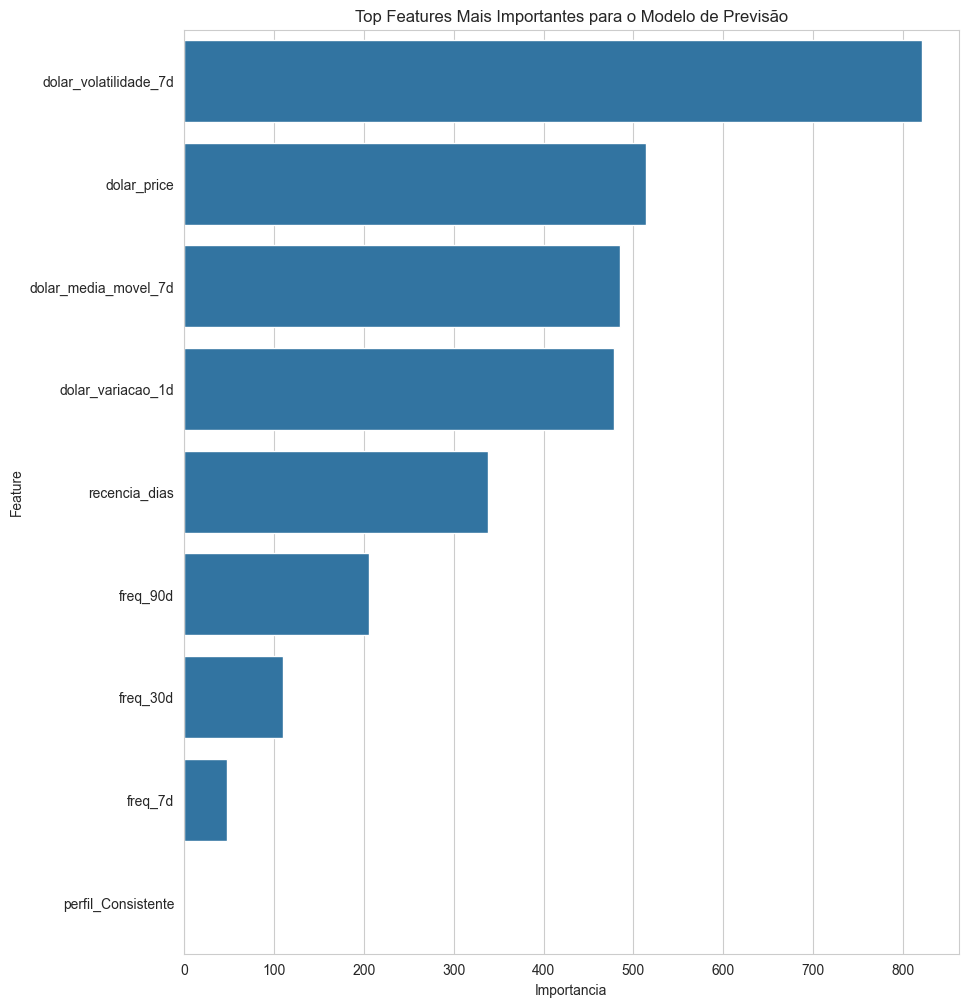

In [11]:

print("--- Análise de Importância das Features do Modelo Final ---")

# 'model_final' é o seu modelo treinado com todos os dados
# 'X.columns' contém o nome de todas as features que o modelo usou

# Cria um DataFrame para visualizar a importância de cada feature
df_importancia = pd.DataFrame({
    'Feature': X.columns,
    'Importancia': model_final.feature_importances_
}).sort_values(by='Importancia', ascending=False)

print("As features mais importantes para o modelo:")
print(df_importancia.head(15).to_string())

# Cria um gráfico de barras para visualizar a importância
plt.figure(figsize=(10, 12))
sns.barplot(x='Importancia', y='Feature', data=df_importancia.head(20))
plt.title('Top Features Mais Importantes para o Modelo de Previsão')
plt.show()

In [12]:
print("--- PASSO FINAL: Coletando DADOS ENRIQUECIDOS para o Assistente de IA ---")


# --- 1. Performance do Modelo ---
report_dict = classification_report(y_test, y_pred, output_dict=True)
precisao_modelo = report_dict['1']['precision']
recall_modelo = report_dict['1']['recall']
acuracia_geral = report_dict['accuracy']
performance_texto = (f"O modelo final (LGBMClassifier) alcançou uma acurácia geral de {acuracia_geral:.2%}. "
                     f"Para a classe de interesse ('Transacionou'), a precisão foi de {precisao_modelo:.2%} e o recall foi de {recall_modelo:.2%}.")

# --- 2. Features Mais e Menos Importantes ---
top_features_texto = df_importancia.head(5).to_markdown(index=False)
bottom_features_texto = df_importancia.tail(3).to_markdown(index=False)

# --- 3. Previsões Finais ---
previsao_04_11_texto = resultados_finais['2024-11-04'].head(10).to_markdown(index=False)
previsao_05_11_texto = resultados_finais['2024-11-05'].head(10).to_markdown(index=False)

# --- 4. Informações Gerais do Dataset ---
# --- NOVO: Adicionando mais detalhes ---
start_date_str = df_completo['Date'].min().strftime('%d/%m/%Y')
end_date_str = df_completo['Date'].max().strftime('%d/%m/%Y')
produtos_analisados = list(df_completo['Product'].unique())
top_5_vendedores_historico = df_completo['Seller ID'].value_counts().head(5).to_markdown()

info_geral_texto = (f"O projeto utilizou um dataset final com {df_final.shape[0]} registros e {df_final.shape[1]} colunas. "
                    f"O período histórico analisado foi de {start_date_str} a {end_date_str}. "
                    f"O objetivo era prever transações para {len(todos_vendedores)} vendedores únicos. "
                    f"Os produtos analisados foram: {produtos_analisados}.")

# --- NOVO: Estatísticas Chave Adicionais ---
dolar_stats_texto = df_dolar['dolar_price'].describe().to_markdown()


# --- Montando o Contexto COMPLETO E ENRIQUECIDO ---
contexto_do_projeto = f"""
# CONTEXTO DO PROJETO DE PREVISÃO DE VENDEDORES

## 1. Objetivo do Projeto
O objetivo foi prever quais vendedores realizariam uma transação de commodities ({produtos_analisados}) nos dias 04/11/2024 e 05/11/2024.

## 2. Dados Analisados
{info_geral_texto}

### Top 5 Vendedores Mais Ativos (Histórico Total):
{top_5_vendedores_historico}

### Estatísticas do Dólar (USD-BRL) no Período:
{dolar_stats_texto}

## 3. Desempenho do Modelo Preditivo
{performance_texto}

## 4. Lógica do Modelo: Features Mais Importantes
O modelo aprendeu que as seguintes features foram as mais decisivas para a previsão:
{top_features_texto}

### Features Menos Importantes:
{bottom_features_texto}

## 5. Previsões Finais (Top 10)
**Para 04/11/2024:**
{previsao_04_11_texto}

**Para 05/11/2024:**
{previsao_05_11_texto}
"""

# print("\nContexto ENRIQUECIDO do projeto coletado e pronto para uso!")
# Para ver o contexto completo que a IA receberá, descomente a linha abaixo
print(contexto_do_projeto) 

--- PASSO FINAL: Coletando DADOS ENRIQUECIDOS para o Assistente de IA ---

# CONTEXTO DO PROJETO DE PREVISÃO DE VENDEDORES

## 1. Objetivo do Projeto
O objetivo foi prever quais vendedores realizariam uma transação de commodities (['Soja', 'Milho']) nos dias 04/11/2024 e 05/11/2024.

## 2. Dados Analisados
O projeto utilizou um dataset final com 747824 registros e 12 colunas. O período histórico analisado foi de 02/01/2024 a 04/11/2024. O objetivo era prever transações para 2428 vendedores únicos. Os produtos analisados foram: ['Soja', 'Milho'].

### Top 5 Vendedores Mais Ativos (Histórico Total):
|   Seller ID |   count |
|------------:|--------:|
|   100000011 |  169237 |
|   100000767 |  136602 |
|   100000790 |  112761 |
|   100000037 |  111438 |
|   100001955 |  111302 |

### Estatísticas do Dólar (USD-BRL) no Período:
|       |   dolar_price |
|:------|--------------:|
| count |    308        |
| mean  |      5.28036  |
| std   |      0.280144 |
| min   |      4.8524   |
| 25%   

In [ ]:
# Em uma nova célula do Jupyter

from openai import OpenAI
import os
from dotenv import load_dotenv


load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# O prompt principal que define o papel da IA
system_prompt = f"""
Você é um Assistente de Data Science. Sua única função é responder perguntas sobre um projeto de Machine Learning já concluído.
Use APENAS o contexto fornecido abaixo para formular suas respostas. Não invente informações.
Se a pergunta não puder ser respondida com o contexto, diga "Esta informação não está disponível no meu contexto."

--- CONTEXTO DO PROJETO ---
{contexto_do_projeto}
--- FIM DO CONTEXTO ---
"""

# Inicializa o histórico da conversa
conversation_history = [{"role": "system", "content": system_prompt}]

print("Olá! Sou seu assistente de análise. Faça perguntas sobre o projeto. (Digite 'sair' para terminar)")

while True:
    user_question = input("Você: ")
    if user_question.lower() == 'sair':
        print("Assistente: Encerrando a sessão. Até logo!")
        break
    
    # Adiciona a pergunta do usuário ao histórico
    conversation_history.append({"role": "user", "content": user_question})
    
    # Faz a chamada para a API
    response = client.chat.completions.create(
        model="gpt-4-turbo",
        messages=conversation_history,
        temperature=0.2 # Baixa temperatura para respostas mais factuais
    )
    
    ai_response = response.choices[0].message.content
    print(f"Assistente: {ai_response}")
    
    # Adiciona a resposta da IA ao histórico para manter o contexto da conversa
    conversation_history.append({"role": "assistant", "content": ai_response})

Olá! Sou seu assistente de análise. Faça perguntas sobre o projeto. (Digite 'sair' para terminar)


Você:  me dê informações sobre o projeto


Assistente: O projeto de previsão de vendedores teve como objetivo prever quais vendedores realizariam uma transação de commodities (Soja e Milho) nos dias 04/11/2024 e 05/11/2024. Utilizou-se um dataset com 747824 registros e 12 colunas, abrangendo o período de 02/01/2024 a 04/11/2024, com foco em 2428 vendedores únicos.

O modelo preditivo utilizado foi o LGBMClassifier, que alcançou uma acurácia geral de 87.54%. A precisão para a classe de interesse ('Transacionou') foi de 2.49% e o recall foi de 50.00%. As features mais importantes identificadas pelo modelo incluíram variáveis relacionadas à volatilidade do dólar, preço do dólar, média móvel do dólar, variação diária do dólar e a recência em dias desde a última transação do vendedor.

As previsões finais indicaram as probabilidades de transação para os vendedores nos dias especificados, com detalhamento das dez maiores probabilidades para cada um dos dois dias.
